In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional
from tqdm.notebook import tqdm
from tqdm import tqdm

import constants, index_tools, data_tools

from utilities import *

# Data Index

In [72]:
biobank_index_full = index_tools.load_index()

In [73]:
biobank_index_full = index_tools.add_udi_names_to_index(biobank_index_full)
udi_map = index_tools.UDIMap(biobank_index_full)

# Load BioBank Data

In [74]:
biobank_data_full = data_tools.load_biobank_data(constants.UK_BIOBANK_DATA_CSV_PATH, udi_map)
biobank_index_full = index_tools.add_biobank_info_to_index(biobank_index_full, biobank_data_full)
display(biobank_data_full.head())

UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns


,eid,NaN,NaN,NaN,sex,birth_year,bp_device,bp_device_1.0,bp_device_2.0,bp_manual_device_ID,...,NaN,NaN,NaN,NaN,important_unlabeled_34,NaN,NaN,NaN,NaN,NaN
0,1000013,485.0,NaN,NaN,1,1962,2817.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18.0,NaN,NaN,NaN,NaN
1,1000024,328.0,NaN,NaN,0,1941,1054.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN
2,1000036,364.0,NaN,NaN,0,1955,3159.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN
3,1000048,322.0,NaN,NaN,1,1941,3780.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18.0,NaN,NaN,NaN,NaN
4,1000055,477.0,NaN,NaN,0,1947,3156.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,6.0,18.0,NaN,NaN,NaN


# Clean + Reduce feature set

In [75]:
biobank_data = data_tools.clean_biobank_data(biobank_data_full)

reduced_feature_set = data_tools.create_reduced_feature_set(biobank_data_full)


biobank_index = biobank_index_full.loc[biobank_index_full["name"].isin(reduced_feature_set)].reset_index(drop=True)
biobank_data = biobank_data_full[reduced_feature_set]

TypeError: argument of type 'NoneType' is not iterable

# BioBank Code Download

In [71]:
index_tools.download_biobank_code_data(code=3, overwrite=True)

In [11]:
index_tools.download_all_biobank_codes(biobank_index)

# Feature Exploration

In [12]:
feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
    unique_features = biobank_data[column].unique()
    feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
    feature_data["feature"].append(column)
    feature_data["n_unique"].append(len(unique_features))
    
feature_data = pd.DataFrame(feature_data)

Analyzing features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 542/542 [00:00<00:00, 4816.93 feature/s]


In [13]:
UK_BIOBANK_FEATURE_VALUE_REMAPPING = {
    "sex": ["female", "male"]
}

# Feature Index EDA

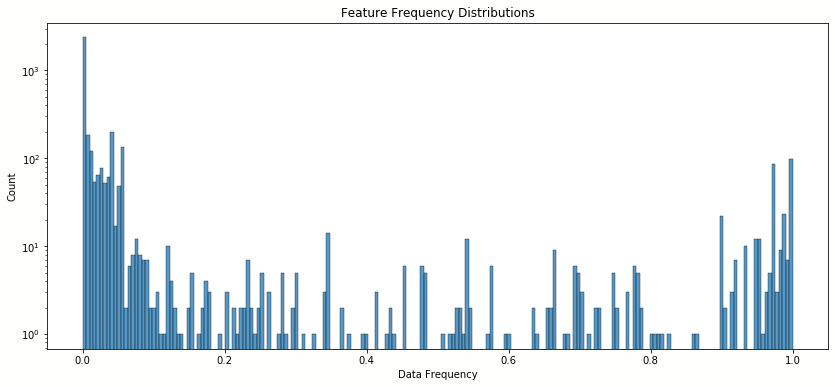

In [14]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.histplot(biobank_index_full["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fffffe")

# actual EDA

In [12]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

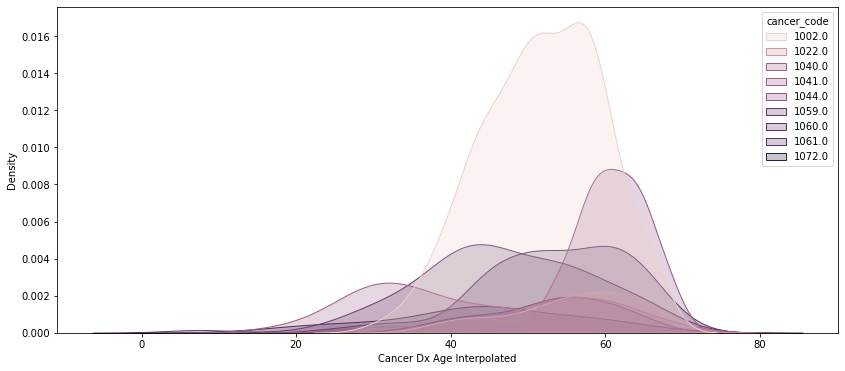

In [13]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[counts > 20]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]


fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax, shade=True)
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_onset_age.png"), facecolor="#fffffe")

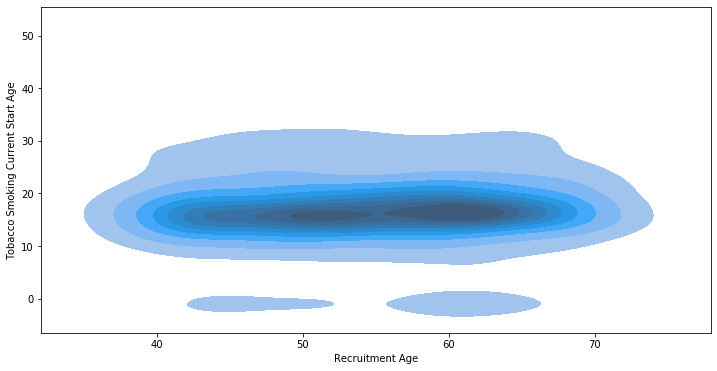

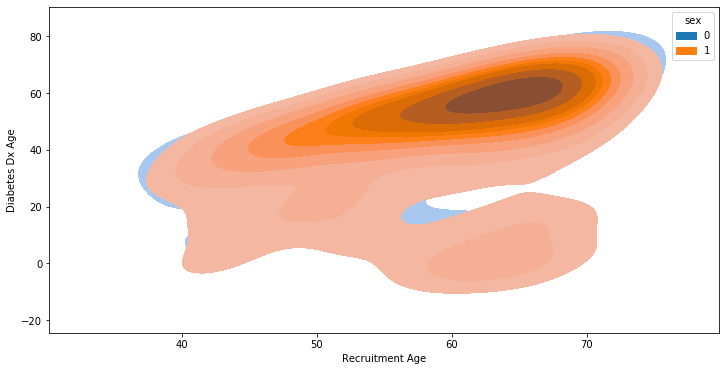

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"

sns.kdeplot(data=biobank_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

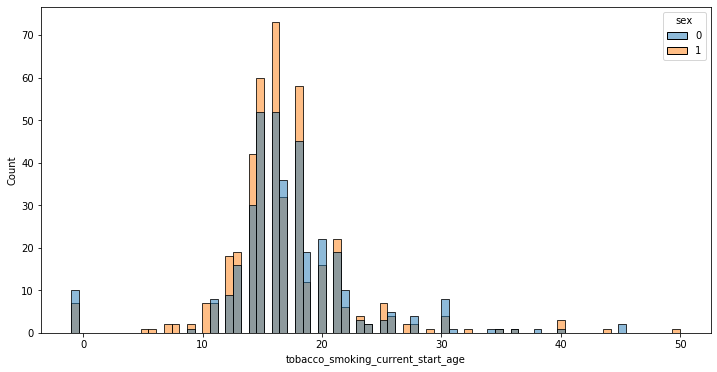

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

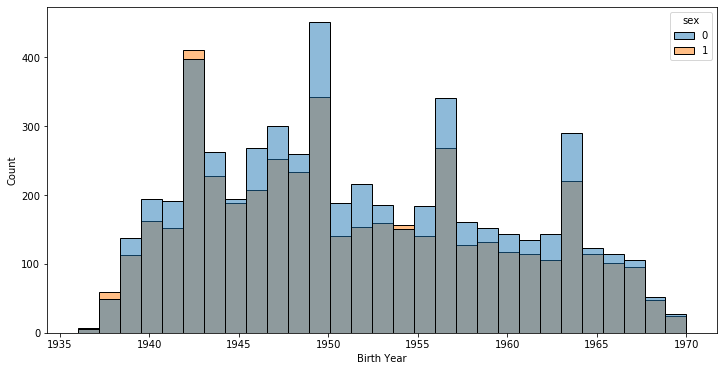

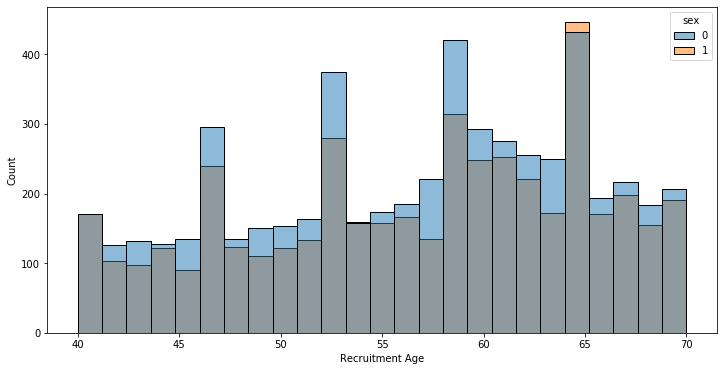

In [16]:
x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")